# Analysis

Clean data.

Multiple time series models.

Clean workspace and github.

In [10]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
df = pd.read_csv("data/prediction.csv")

df_month = df.groupby(['year', 'month'])['gross_weight'].sum().reset_index()
df_month['date'] = pd.to_datetime(df_month[['year', 'month']].assign(day=1))

In [ ]:
print(df_month)

In [ ]:
plt.figure()
plt.plot(df_month['date'], df_month['gross_weight'])
plt.yscale('log')
plt.show()


print(df_month)

In [ ]:
df_disaster = pd.read_csv("data/disaster.csv")

df_disaster['date'] = pd.to_datetime(df_disaster['End Date'], format='%Y%m%d')

In [ ]:
print(df_disaster.columns)

In [ ]:
fig, ax1 = plt.subplots()

ax1.bar(df_disaster['date'], df_disaster['Unadjusted Cost'], width=20, color='red')

ax2 = ax1.twinx()
ax2.plot(df_month['date'], df_month['gross_weight'])
ax2.set_yscale('log')

plt.show()

In [ ]:
fig, ax1 = plt.subplots()

ax1.bar(df_disaster['date'], df_disaster['CPI-Adjusted Cost'], width=20, color='red')

ax2 = ax1.twinx()
ax2.plot(df_month['date'], df_month['gross_weight'])
ax2.set_yscale('log')

plt.show()

In [ ]:
fig, ax1 = plt.subplots()

ax1.bar(df_disaster['date'], df_disaster['Deaths'], width=20, color='red')

ax2 = ax1.twinx()
ax2.plot(df_month['date'], df_month['gross_weight'])
ax2.set_yscale('log')

plt.show()

Katrina had almost no impact on donations.

2008 is unexplained.

Outlier donations are:

2008: ConAgra

2014: Quaker?

2018: Mondelez

Replace the outlier with the **mean** contribution.

Need to nuke when one organization donates an outsized amount. Establish this in terms of donor/month donations.

In [ ]:
df = pd.read_csv("data/prediction.csv")
df.to_csv("data/prediction.csv", index=False)

In [48]:
# contribution mean

df = pd.read_csv("data/prediction.csv")

print(df['gross_weight'].describe())

count    4.064930e+05
mean     1.554203e+03
std      1.990067e+05
min      0.000000e+00
25%      1.300000e+01
50%      3.800000e+01
75%      2.327010e+02
max      1.146416e+08
Name: gross_weight, dtype: float64


Grab outliers within each branch.

<Axes: ylabel='Frequency'>

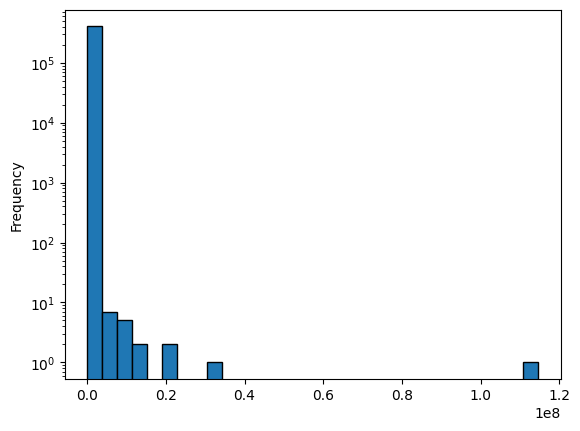

In [49]:
df['gross_weight'].plot(kind='hist', bins=30, edgecolor='black', logy=True)

In [50]:
n_months = 262 # since 2003

df_encoded = pd.get_dummies(df, columns=['donor_id'], dtype=int)
df_encoded = df_encoded.drop(['date', 'gross_weight', 'branch_code', 'storage_code'], axis=1)
df_encoded = df_encoded.groupby(['year', 'month'], as_index=False).sum()

df_encoded = df_encoded.map(lambda x: 1 if x != 0 else 0)
df_encoded.to_csv("encoded.csv", index=False)

In [51]:
donors = df['donor_id'].unique()

donor_dict = {}

for donor in donors:
    if str(donor) == 'nan': continue
    donor = 'donor_id_' + str(donor)
    donor_dict[donor] = df_encoded[donor].sum()

for donor in donor_dict.keys():
    donor_dict[donor] /= n_months

print(donor_dict)

df_reliability = pd.DataFrame.from_dict(donor_dict, orient='index', columns=['reliability_score'])
df_reliability.to_csv("reliability.csv", index=False)

{'donor_id_ConAgraDairy': 0.11068702290076336, 'donor_id_Penske': 0.003816793893129771, 'donor_id_Kraft': 0.7480916030534351, 'donor_id_Kellogg': 0.9465648854961832, 'donor_id_PenskeTX': 0.015267175572519083, 'donor_id_OceanSpray': 0.06870229007633588, 'donor_id_Quaker': 0.2595419847328244, 'donor_id_Welchs': 0.022900763358778626, 'donor_id_Kinkos': 0.007633587786259542, 'donor_id_NestleHandHeld': 0.061068702290076333, 'donor_id_ConAgraLogistics': 0.007633587786259542, 'donor_id_HersheyChocolate': 0.4122137404580153, 'donor_id_ConAgraPotato': 0.4122137404580153, 'donor_id_ConAgraGrocery': 0.7366412213740458, 'donor_id_Sunsweet': 0.05343511450381679, 'donor_id_ConAgraSnackFoods': 0.011450381679389313, 'donor_id_ConAgraRefrigerated': 0.011450381679389313, 'donor_id_Barilla': 0.5572519083969466, 'donor_id_Atlanta': 0.3320610687022901, 'donor_id_Valdosta': 0.33969465648854963, 'donor_id_Tropicana': 0.08015267175572519, 'donor_id_Athens': 0.13358778625954199, 'donor_id_ConAgraFrozen': 0.030

In [ ]:
df = pd.read_csv("reliability.csv")

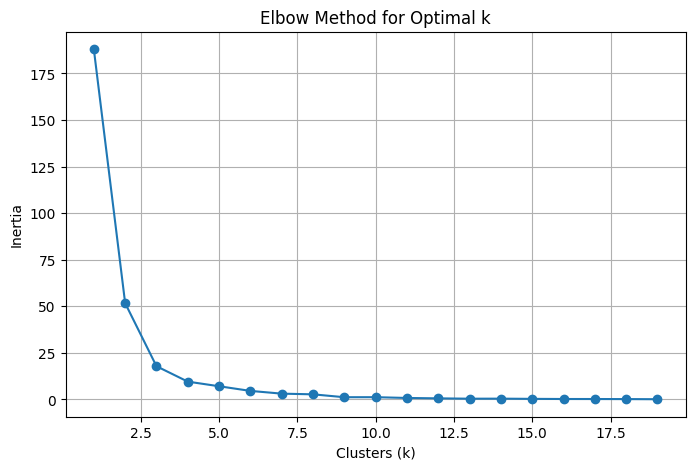

In [53]:
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

df = pd.DataFrame(df['reliability_score'])

e_scaled = StandardScaler().fit_transform(df) # this is super important

inertia = []
k_range = range(1, 20)

for k in k_range:
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(e_scaled)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(8, 5))
plt.plot(k_range, inertia, marker='o')
plt.title("Elbow Method for Optimal k")
plt.xlabel("Clusters (k)")
plt.ylabel("Inertia")
plt.grid(True)
plt.show()

In [54]:
df_reliability = df_reliability.reset_index(names='donor_id')

print(df_reliability.columns)

Index(['donor_id', 'reliability_score'], dtype='object')


In [55]:
km = KMeans(n_clusters=3)
km.fit(e_scaled)

df_reliability['group'] = km.labels_

print(km.labels_)
print(df_reliability)

[0 0 2 2 0 0 1 0 0 0 0 1 1 2 0 0 0 2 1 1 0 0 0 0 2 0 0 1 0 0 0 0 0 0 0 0 0
 0 0 1 1 0 1 0 0 0 1 0 1 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
                     donor_id  reliability_score  group
0       donor_id_ConAgraDairy           0.110687      0
1             donor_id_Penske           0.003817      0
2              donor_id_Kraft           0.748092      2
3            donor_id_Kellogg           0.946565      2
4           donor_id_PenskeTX           0.015267      0
..                        ...                ...    ...
183  donor_id_Smithfieldfoods           0.003817      0
184     donor_id_Headquarters           0.003817      0
185          donor_id_KaChava           0.007634      0
186    donor_id_SchwansGlobal           0.011450      0
1

In [56]:
# clean donor_id

df_reliability['donor_id'] = df_reliability['donor_id'].str.replace('donor_id_', '', regex=False)

print(df_reliability)

            donor_id  reliability_score  group
0       ConAgraDairy           0.110687      0
1             Penske           0.003817      0
2              Kraft           0.748092      2
3            Kellogg           0.946565      2
4           PenskeTX           0.015267      0
..               ...                ...    ...
183  Smithfieldfoods           0.003817      0
184     Headquarters           0.003817      0
185          KaChava           0.007634      0
186    SchwansGlobal           0.011450      0
187            GHOST           0.003817      0

[188 rows x 3 columns]


In [11]:
df_prediction = pd.read_csv("data/prediction.csv")

df_merge = pd.merge(df_prediction, df_reliability, on='donor_id')

df_merge.to_csv("data/final.csv", index=False)

NameError: name 'df_reliability' is not defined

In [ ]:
rename_dict = {
    'DRY': ['DRY', 'FRESH'],
    'FROZEN': ['FROZEN'],
    'REFRIG': ['REF', 'REFRIG', 'Refrigerated']
}

rename_map = {old: new for new, olds in rename_dict.items() for old in olds}

df['storage_code'] = df['storage_code'].map(lambda x: rename_map.get(x, x))

df.to_csv("data/final.csv", index=False)

In [62]:
df = pd.read_csv("data/final.csv")

print(df)

              date      donor_id  gross_weight  ... month reliability_score  group
0       2002-12-20  ConAgraDairy        17.500  ...    12          0.110687      0
1       2002-12-20  ConAgraDairy       198.000  ...    12          0.110687      0
2       2002-12-20  ConAgraDairy      1464.000  ...    12          0.110687      0
3       2002-12-27  ConAgraDairy         7.500  ...    12          0.110687      0
4       2002-12-27  ConAgraDairy        20.000  ...    12          0.110687      0
...            ...           ...           ...  ...   ...               ...    ...
406523  2024-10-10         Kraft       168.000  ...    10          0.748092      2
406524  2024-10-10         Kraft       396.630  ...    10          0.748092      2
406525  2024-10-10         Kraft       396.900  ...    10          0.748092      2
406526  2024-10-10         Kraft       942.126  ...    10          0.748092      2
406527  2024-10-10         Kraft      1910.538  ...    10          0.748092      2

[40

In [63]:
# Create a boolean Series where 'gross_weight' is NOT greater than 5000.0
# This selects the rows you want to KEEP
filter = df['gross_weight'] <= 5000.0

# Use boolean indexing to select the rows that satisfy the condition
df = df[filter]

In [64]:
# by storage code/food type

df_storage_dict = {storage: g for storage, g in df.groupby('storage_code')}

for storage in df_storage_dict.keys():
    df_storage_dict[storage] = {group: g for group, g in df_storage_dict[storage].groupby('group')}

print(df_storage_dict)

{'DRY': {0:               date    donor_id  gross_weight  ... month reliability_score  group
761     2003-11-18  OceanSpray       2380.00  ...    11          0.068702      0
1062    2004-02-05  OceanSpray       1820.70  ...     2          0.068702      0
1063    2004-02-05  OceanSpray       3641.40  ...     2          0.068702      0
1162    2004-02-11      Welchs       3648.00  ...     2          0.022901      0
1228    2004-03-19      Kinkos        100.00  ...     3          0.007634      0
...            ...         ...           ...  ...   ...               ...    ...
406215  2024-10-12   Bumblebee        186.00  ...    10          0.022901      0
406216  2024-10-12   Bumblebee       1782.00  ...    10          0.022901      0
406217  2024-10-12   Bumblebee       2480.85  ...    10          0.022901      0
406218  2024-10-12   Bumblebee       2807.19  ...    10          0.022901      0
406219  2024-10-12   Bumblebee       3789.54  ...    10          0.022901      0

[8640 rows x 9 

In [65]:
for food in df_storage_dict.keys():
    df_group_dict = df_storage_dict[food]
    for group in df_group_dict.keys():
        print(food, group, df_group_dict[group]['gross_weight'].median())

DRY 0 263.52
DRY 1 28.142
DRY 2 34.0
FROZEN 0 452.125
FROZEN 1 569.5
FROZEN 2 99.638
REF 0 440.0
REF 1 2609.0
REF 2 320.0
REFRIG 0 384.0
REFRIG 1 25.0
REFRIG 2 273.0
Refrigerated 0 206.25
Refrigerated 1 263.9
Refrigerated 2 26.082


In [66]:
for food in df_storage_dict.keys():
    df_group_dict = df_storage_dict[food]
    for group in df_group_dict.keys():
        print(food, group, df_group_dict[group].describe)

DRY 0 <bound method NDFrame.describe of               date    donor_id  gross_weight  ... month reliability_score  group
761     2003-11-18  OceanSpray       2380.00  ...    11          0.068702      0
1062    2004-02-05  OceanSpray       1820.70  ...     2          0.068702      0
1063    2004-02-05  OceanSpray       3641.40  ...     2          0.068702      0
1162    2004-02-11      Welchs       3648.00  ...     2          0.022901      0
1228    2004-03-19      Kinkos        100.00  ...     3          0.007634      0
...            ...         ...           ...  ...   ...               ...    ...
406215  2024-10-12   Bumblebee        186.00  ...    10          0.022901      0
406216  2024-10-12   Bumblebee       1782.00  ...    10          0.022901      0
406217  2024-10-12   Bumblebee       2480.85  ...    10          0.022901      0
406218  2024-10-12   Bumblebee       2807.19  ...    10          0.022901      0
406219  2024-10-12   Bumblebee       3789.54  ...    10          0.02

In [67]:
# clean outliers
for food in df_storage_dict.keys():
    df_group_dict = df_storage_dict[food]
    for group in df_group_dict.keys():
        cluster = df_group_dict[group]
        weight = cluster['gross_weight']
        q1 = weight.quantile(0.25)
        q3 = weight.quantile(0.75)
        iqr = q3 - q1

        lower = q1 - 0.8 * iqr
        upper = q3 + 2 * iqr

        median = cluster['gross_weight'].median()

        cluster['gross_weight'] = cluster['gross_weight'].apply(lambda x: median if x < lower or x > upper else x)
        cluster.to_csv(f"data/clusters/final_{food}_{group}.csv")

/var/folders/nd/ltpj3cdx35932ptv34l_50r00000gn/T/ipykernel_50338/2922691655.py:10: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(cluster['date'], cluster['gross_weight'], s = 1, c = colors[group])


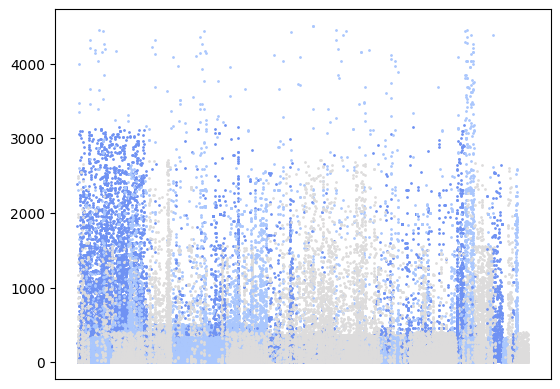

In [68]:
palette = sns.color_palette("coolwarm", 5)
colors = [palette[label] for label in range(3)]

for food in df_storage_dict.keys():
    df_group_dict = df_storage_dict[food]
    for group in df_group_dict.keys():
            # also f"data/clusters/final_{food}_{group}.csv"
            cluster = df_group_dict[group]

            plt.scatter(cluster['date'], cluster['gross_weight'], s = 1, c = colors[group])

plt.xticks([])
plt.show()

In [70]:
# split into train/test
# function to apply to each cluster

def train_test_split(df):
    if df.size < 50 + 12: return None, None # min train + test for valid arima
    train = df[:-12]
    test = df[-12:]
    return train, test

In [73]:
from collections import defaultdict
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error

import numpy as np
import pandas as pd
import pmdarima as pm

from statsmodels.tsa.holtwinters import ExponentialSmoothing
from prophet import Prophet

model_dict = {
    "ARIMA": defaultdict(dict),
    "ETS": defaultdict(dict),
    "Prophet": defaultdict(dict)
}

for food in df_storage_dict.keys():
    print(f"Processing food type: {food}")
    df_group_dict = df_storage_dict[food]

    for group in df_group_dict.keys():
        cluster = f"{food}_{group}"
        original_cluster_df = df_group_dict[group]

        print(f"  Processing cluster: {cluster} with raw shape {original_cluster_df.shape}")

        # Prepare
        cluster_df = original_cluster_df.loc[:, ['date', 'gross_weight']].copy()

        cluster_df['date'] = pd.to_datetime(cluster_df['date'])

        cluster_df_agg = cluster_df.groupby('date')['gross_weight'].sum().reset_index()

        cluster_df_agg.set_index('date', inplace=True)

        assembled_series = cluster_df_agg['gross_weight']

        # fill missing
        if not assembled_series.empty:
            full_range = pd.date_range(start=assembled_series.index.min(), end=assembled_series.index.max(), freq='MS')
        else:
            print(f"    Skipping cluster {cluster}: Aggregated series is empty.")
            continue

        y_values_reindexed = assembled_series.reindex(full_range)

        y_values_filled = y_values_reindexed.interpolate(method='linear')

        # split
        try:
            split_point = int(len(y_values_filled) * 0.8)
            train = y_values_filled[:split_point]
            test = y_values_filled[split_point:]
        except Exception as e:
             print(f"    Error during train/test split for cluster {cluster}: {e}")
             continue
        
        # check/validate
        if not train.empty and not test.empty:
             print(f"    Train shape: {train.shape}, Test shape: {test.shape}")
        else:
            print(f"    Skipping cluster {cluster}: Insufficient data for training or testing after split.")
            continue

        # drop nan
        train_cleaned = train.dropna()
        test_cleaned = test.dropna()

        if train_cleaned.empty or test_cleaned.empty:
             print(f"    Skipping cluster {cluster}: Not enough data after dropping remaining NaNs.")
             continue
        else:
            print(f"    Cleaned Train shape: {train_cleaned.shape}, Cleaned Test shape: {test_cleaned.shape}")

        # models
        for model_name in model_dict.keys():
            print(f"    Processing {model_name} for {cluster}")

            model = None
            forecast = None

            # arima
            if model_name == "ARIMA":
                try:
                    model = pm.auto_arima(
                        train_cleaned,
                        start_p=1, start_q=1,
                        max_p=5, max_q=5,
                        seasonal=True,
                        m=12,
                        stepwise=True,
                        error_action='ignore',
                        suppress_warnings=True,
                        n_fits=50
                    )
                    forecast = model.predict(len(test_cleaned))

                except Exception as e:
                    print(f"      ARIMA fitting failed for {cluster}: {e}")
                    continue

            elif model_name == "ETS":
                try:
                    model = ExponentialSmoothing(
                        train_cleaned,
                        trend='add',
                        seasonal='add',
                        seasonal_periods=12
                    ).fit()
                    forecast = model.forecast(len(test_cleaned))

                except Exception as e:
                    print(f"      ETS fitting failed for {cluster}: {e}")
                    continue

            # prohpet
            elif model_name == "Prophet":
                try:
                    train_prophet_df = pd.DataFrame({'ds': train_cleaned.index, 'y': train_cleaned.values})

                    model = Prophet(
                        yearly_seasonality=True,
                        weekly_seasonality=False,
                        daily_seasonality=False
                    )
                    model.fit(train_prophet_df)

                    future = pd.DataFrame({'ds': test_cleaned.index})
                    forecast_df = model.predict(future)

                    forecast = forecast_df.set_index('ds').reindex(test_cleaned.index)['yhat'].values

                except Exception as e:
                    print(f"      Prophet fitting failed for {cluster}: {e}")
                    continue

            if model is not None and forecast is not None:
                model_dict[model_name][cluster]["forecast"] = forecast.tolist()

                model_dict[model_name][cluster]["stats"] = {
                    "MAE": mean_absolute_error(test_cleaned, forecast) if len(test_cleaned) == len(forecast) else np.nan,
                    "MAPE": mean_absolute_percentage_error(test_cleaned, forecast) if len(test_cleaned) == len(forecast) else np.nan,
                    "RMSE": np.sqrt(mean_squared_error(test_cleaned, forecast)) if len(test_cleaned) == len(forecast) else np.nan
                }
            else:
                print(f"    Did not get a valid model or forecast for {model_name} in {cluster}")


Processing food type: DRY
  Processing cluster: DRY_0 with raw shape (8640, 9)
    Train shape: (200,), Test shape: (51,)
    Cleaned Train shape: (128,), Cleaned Test shape: (51,)
    Processing ARIMA for DRY_0


/Users/michi/Emory/aidata/tech-bridge-26/.venv/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/michi/Emory/aidata/tech-bridge-26/.venv/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/michi/Emory/aidata/tech-bridge-26/.venv/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/michi/Emory/aidata/tech-bridge-26/.venv/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/michi/Emory/aidata/tech-bridge-26/.venv/lib/python3.11/site-packages/

    Adding results for ARIMA in DRY_0
    Processing ETS for DRY_0
    Adding results for ETS in DRY_0
    Processing Prophet for DRY_0
    Adding results for Prophet in DRY_0
  Processing cluster: DRY_1 with raw shape (98679, 9)
    Train shape: (200,), Test shape: (51,)
    Cleaned Train shape: (162,), Cleaned Test shape: (51,)
    Processing ARIMA for DRY_1


/Users/michi/Emory/aidata/tech-bridge-26/.venv/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/michi/Emory/aidata/tech-bridge-26/.venv/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/michi/Emory/aidata/tech-bridge-26/.venv/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/michi/Emory/aidata/tech-bridge-26/.venv/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/michi/Emory/aidata/tech-bridge-26/.venv/lib/python3.11/site-packages/

    Adding results for ARIMA in DRY_1
    Processing ETS for DRY_1
    Adding results for ETS in DRY_1
    Processing Prophet for DRY_1
    Adding results for Prophet in DRY_1
  Processing cluster: DRY_2 with raw shape (209857, 9)
    Train shape: (206,), Test shape: (52,)
    Cleaned Train shape: (195,), Cleaned Test shape: (52,)
    Processing ARIMA for DRY_2


/Users/michi/Emory/aidata/tech-bridge-26/.venv/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/michi/Emory/aidata/tech-bridge-26/.venv/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/michi/Emory/aidata/tech-bridge-26/.venv/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/michi/Emory/aidata/tech-bridge-26/.venv/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/michi/Emory/aidata/tech-bridge-26/.venv/lib/python3.11/site-packages/

    Adding results for ARIMA in DRY_2
    Processing ETS for DRY_2
    Adding results for ETS in DRY_2
    Processing Prophet for DRY_2
    Adding results for Prophet in DRY_2
Processing food type: FROZEN
  Processing cluster: FROZEN_0 with raw shape (3702, 9)
    Train shape: (197,), Test shape: (50,)
    Cleaned Train shape: (175,), Cleaned Test shape: (50,)
    Processing ARIMA for FROZEN_0


/Users/michi/Emory/aidata/tech-bridge-26/.venv/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/michi/Emory/aidata/tech-bridge-26/.venv/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/michi/Emory/aidata/tech-bridge-26/.venv/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/michi/Emory/aidata/tech-bridge-26/.venv/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/michi/Emory/aidata/tech-bridge-26/.venv/lib/python3.11/site-packages/

    Adding results for ARIMA in FROZEN_0
    Processing ETS for FROZEN_0
    Adding results for ETS in FROZEN_0
    Processing Prophet for FROZEN_0
    Adding results for Prophet in FROZEN_0
  Processing cluster: FROZEN_1 with raw shape (3236, 9)
    Train shape: (177,), Test shape: (45,)
    Cleaned Train shape: (175,), Cleaned Test shape: (45,)
    Processing ARIMA for FROZEN_1


/Users/michi/Emory/aidata/tech-bridge-26/.venv/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/michi/Emory/aidata/tech-bridge-26/.venv/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/michi/Emory/aidata/tech-bridge-26/.venv/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/michi/Emory/aidata/tech-bridge-26/.venv/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/michi/Emory/aidata/tech-bridge-26/.venv/lib/python3.11/site-packages/

    Adding results for ARIMA in FROZEN_1
    Processing ETS for FROZEN_1
    Adding results for ETS in FROZEN_1
    Processing Prophet for FROZEN_1
    Adding results for Prophet in FROZEN_1
  Processing cluster: FROZEN_2 with raw shape (15424, 9)
    Train shape: (204,), Test shape: (51,)
    Cleaned Train shape: (161,), Cleaned Test shape: (51,)
    Processing ARIMA for FROZEN_2


/Users/michi/Emory/aidata/tech-bridge-26/.venv/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/michi/Emory/aidata/tech-bridge-26/.venv/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/michi/Emory/aidata/tech-bridge-26/.venv/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/michi/Emory/aidata/tech-bridge-26/.venv/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/michi/Emory/aidata/tech-bridge-26/.venv/lib/python3.11/site-packages/

    Adding results for ARIMA in FROZEN_2
    Processing ETS for FROZEN_2
    Adding results for ETS in FROZEN_2
    Processing Prophet for FROZEN_2
    Adding results for Prophet in FROZEN_2
Processing food type: REF
  Processing cluster: REF_0 with raw shape (23, 9)
    Train shape: (36,), Test shape: (10,)
    Cleaned Train shape: (35,), Cleaned Test shape: (10,)
    Processing ARIMA for REF_0
    Adding results for ARIMA in REF_0
    Processing ETS for REF_0
    Adding results for ETS in REF_0
    Processing Prophet for REF_0
    Adding results for Prophet in REF_0
  Processing cluster: REF_1 with raw shape (15, 9)
    Train shape: (65,), Test shape: (17,)
    Skipping cluster REF_1: Not enough data after dropping remaining NaNs.
  Processing cluster: REF_2 with raw shape (6, 9)
    Train shape: (1,), Test shape: (1,)
    Skipping cluster REF_2: Not enough data after dropping remaining NaNs.
Processing food type: REFRIG
  Processing cluster: REFRIG_0 with raw shape (1711, 9)
    Tra

/Users/michi/Emory/aidata/tech-bridge-26/.venv/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/michi/Emory/aidata/tech-bridge-26/.venv/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/michi/Emory/aidata/tech-bridge-26/.venv/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/michi/Emory/aidata/tech-bridge-26/.venv/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/michi/Emory/aidata/tech-bridge-26/.venv/lib/python3.11/site-packages/

    Adding results for ARIMA in REFRIG_0
    Processing ETS for REFRIG_0
    Adding results for ETS in REFRIG_0
    Processing Prophet for REFRIG_0
    Adding results for Prophet in REFRIG_0
  Processing cluster: REFRIG_1 with raw shape (24750, 9)
    Train shape: (132,), Test shape: (34,)
    Cleaned Train shape: (30,), Cleaned Test shape: (34,)
    Processing ARIMA for REFRIG_1


/Users/michi/Emory/aidata/tech-bridge-26/.venv/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/michi/Emory/aidata/tech-bridge-26/.venv/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/michi/Emory/aidata/tech-bridge-26/.venv/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/michi/Emory/aidata/tech-bridge-26/.venv/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/michi/Emory/aidata/tech-bridge-26/.venv/lib/python3.11/site-packages/

    Adding results for ARIMA in REFRIG_1
    Processing ETS for REFRIG_1
    Adding results for ETS in REFRIG_1
    Processing Prophet for REFRIG_1
    Adding results for Prophet in REFRIG_1
  Processing cluster: REFRIG_2 with raw shape (5947, 9)
    Train shape: (140,), Test shape: (36,)
    Cleaned Train shape: (137,), Cleaned Test shape: (36,)
    Processing ARIMA for REFRIG_2


/Users/michi/Emory/aidata/tech-bridge-26/.venv/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/michi/Emory/aidata/tech-bridge-26/.venv/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/michi/Emory/aidata/tech-bridge-26/.venv/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/michi/Emory/aidata/tech-bridge-26/.venv/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/michi/Emory/aidata/tech-bridge-26/.venv/lib/python3.11/site-packages/

    Adding results for ARIMA in REFRIG_2
    Processing ETS for REFRIG_2
    Adding results for ETS in REFRIG_2
    Processing Prophet for REFRIG_2
    Adding results for Prophet in REFRIG_2
Processing food type: Refrigerated
  Processing cluster: Refrigerated_0 with raw shape (185, 9)
    Train shape: (46,), Test shape: (12,)
    Skipping cluster Refrigerated_0: Not enough data after dropping remaining NaNs.
  Processing cluster: Refrigerated_1 with raw shape (3780, 9)
    Train shape: (64,), Test shape: (16,)
    Cleaned Train shape: (62,), Cleaned Test shape: (16,)
    Processing ARIMA for Refrigerated_1
    Adding results for ARIMA in Refrigerated_1
    Processing ETS for Refrigerated_1


/Users/michi/Emory/aidata/tech-bridge-26/.venv/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/michi/Emory/aidata/tech-bridge-26/.venv/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/michi/Emory/aidata/tech-bridge-26/.venv/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/michi/Emory/aidata/tech-bridge-26/.venv/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/michi/Emory/aidata/tech-bridge-26/.venv/lib/python3.11/site-packages/

    Adding results for ETS in Refrigerated_1
    Processing Prophet for Refrigerated_1
    Adding results for Prophet in Refrigerated_1
  Processing cluster: Refrigerated_2 with raw shape (20277, 9)
    Train shape: (64,), Test shape: (17,)
    Cleaned Train shape: (61,), Cleaned Test shape: (17,)
    Processing ARIMA for Refrigerated_2


/Users/michi/Emory/aidata/tech-bridge-26/.venv/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/michi/Emory/aidata/tech-bridge-26/.venv/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/michi/Emory/aidata/tech-bridge-26/.venv/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/michi/Emory/aidata/tech-bridge-26/.venv/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/michi/Emory/aidata/tech-bridge-26/.venv/lib/python3.11/site-packages/

    Adding results for ARIMA in Refrigerated_2
    Processing ETS for Refrigerated_2
    Adding results for ETS in Refrigerated_2
    Processing Prophet for Refrigerated_2
    Adding results for Prophet in Refrigerated_2

--- Final Results ---


In [74]:
import pprint

pprint.pprint(model_dict)

{'ARIMA': defaultdict(<class 'dict'>,
                      {'DRY_0': {'forecast': [19997.554392251484,
                                              20001.547840588704,
                                              20003.78764866713,
                                              20004.605130624102,
                                              20004.377535798554,
                                              20003.472020079433,
                                              20002.209072200734,
                                              20000.842992978985,
                                              19999.555960226186,
                                              19998.461872476095,
                                              19997.616349846197,
                                              19997.02978825545,
                                              19996.68104855573,
                                              19996.53008560662,
                                          